<a href="https://colab.research.google.com/github/phamthanhlam0201/MachineLearning/blob/main/FireAndSmokeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization,Dense,SeparableConv2D,MaxPooling2D,Activation,Flatten,Dropout

In [3]:
# define the initial learning rate, batch size, and number of epochs

INIT_LR = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 50
decay_rate = 0.1
decay_steps = 1000

classes = ['Non-Fire and Smoke','Fire and Smoke']

In [4]:
!pip install wget

import wget
import os

# Đường dẫn của repository trên GitHub
repo_url = 'https://github.com/phamthanhlam0201/MachineLearning'

# Thư mục đích để lưu trữ dữ liệu
destination_folder = './Dataset'

# Tạo thư mục đích nếu chưa tồn tại
os.makedirs(destination_folder, exist_ok=True)

# Tải xuống các tệp từ repository
wget.download(f'{repo_url}/archive/main.zip', f'{destination_folder}/data.zip')

# Giải nén tệp zip
import zipfile
with zipfile.ZipFile(f'{destination_folder}/data.zip', 'r') as zip_ref:
    zip_ref.extractall(destination_folder)


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=e71403c1fca635f05aafbc1425b3b2bd890d4c736fcab115ab28d14a69018836
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [5]:
# Data

root_dir = "/content/Dataset/MachineLearning-main/Dataset"

new_width = 128
new_height = 128

data = []
labels = []

for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path,file_name)

            img = cv2.imread(img_path)
            resized_img = cv2.resize(img,(new_width, new_height))

            data.append(resized_img)
            label = 1 if folder_name == "Fire and Smoke" else 0
            labels.append(label)

data = np.array(data, dtype = "float32")/255
labels = np.array(labels)
labels = np_utils.to_categorical(labels, num_classes = 2)

In [6]:
num_images = data.shape[0]
print("Số lượng ảnh trong data:", num_images)

Số lượng ảnh trong data: 9000


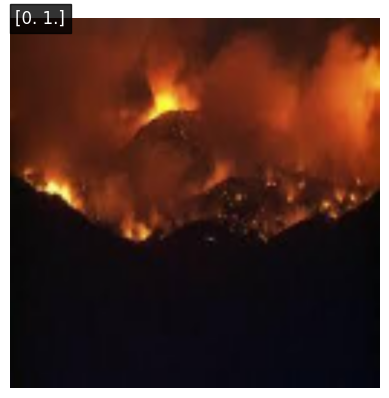

In [8]:
# just visualizing random images from the dataset created above

index = np.random.randint(0, len(data))
image = cv2.resize(data[index], (720, 720))
label = str(labels[index])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.text(10, 10, label, color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.8))
plt.axis('off')  # Ẩn trục
plt.show()

In [9]:
# Chia tập còn lại thành tập train và tập validation + test
train_data, remaining_data, train_labels, remaining_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

# Chia dữ liệu thành tập test và tập còn lại (validation + train)
val_data, test_data, val_labels, test_labels = train_test_split(remaining_data, remaining_labels, test_size=0.5, random_state=42)


In [10]:
print("Số lượng ảnh trong tập train_data:",train_data.shape[0])
print("Số lượng ảnh trong tập val_data:",val_data.shape[0])
print("Số lượng ảnh trong tập test_data:",test_data.shape[0])

Số lượng ảnh trong tập train_data: 6300
Số lượng ảnh trong tập val_data: 1350
Số lượng ảnh trong tập test_data: 1350


In [11]:
# Trong đoạn mã trên, đối tượng aug của lớp ImageDataGenerator được tạo để áp
# dụng các phép biến đổi dữ liệu tăng cường (data augmentation) cho ảnh.

# Các tham số trong ImageDataGenerator xác định các phép biến đổi cụ thể:

# rotation_range: Đặt giới hạn cho phạm vi ngẫu nhiên của góc quay (rotation) của ảnh.
# Trong trường hợp này, góc quay có thể nằm trong khoảng -30 đến +30 độ.

# zoom_range: Đặt giới hạn cho phạm vi ngẫu nhiên của phóng to (zoom) hoặc thu nhỏ ảnh.
# Trong trường hợp này, ảnh có thể được phóng to hoặc thu nhỏ với tỷ lệ nằm trong khoảng từ 0.85 đến 1.15.

# width_shift_range và height_shift_range: Đặt giới hạn cho phạm vi ngẫu nhiên của dịch chuyển ngang (horizontal shift)
# và dịch chuyển dọc (vertical shift) của ảnh. Trong trường hợp này, ảnh có thể được dịch chuyển theo
# chiều ngang và chiều dọc trong khoảng từ -20% đến +20% của kích thước ảnh.

# shear_range: Đặt giới hạn cho phạm vi ngẫu nhiên của biến dạng cắt ảnh (shear). Trong trường hợp này,
# ảnh có thể bị biến dạng cắt với một góc cắt nằm trong khoảng từ -15 đến +15 độ.

# horizontal_flip: Xác định xem ảnh có bị lật ngang (horizontal flip) ngẫu nhiên hay không.
# Trong trường hợp này, ảnh có thể bị lật ngang với xác suất 50%.

# fill_mode: Xác định cách điền các pixel mới khi thực hiện các phép biến đổi dẫn đến mất mát thông tin pixel.
# Trong trường hợp này, sử dụng fill_mode "nearest" để điền các pixel bị thiếu bằng các pixel gần nhất.

# Tổng quát, đối tượng aug được tạo để tạo ra các phiên bản biến đổi khác nhau của ảnh gốc, tăng cường độ đa
# dạng của dữ liệu huấn luyện và giúp mô hình phân loại tổng quát hơn và chống lại hiện tượng overfitting.

data_augmentation = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [12]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=decay_steps,
    decay_rate=decay_rate
)

In [13]:
model = Sequential()

# CONV => RELU => POOL
model.add(SeparableConv2D(16,(7,7),padding='same',input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => POOL
model.add(SeparableConv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV => RELU => CONV => RELU => POOL
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


# second set of FC => RELU layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(len(classes)))
model.add(Activation("softmax"))

opt = SGD(learning_rate=lr_schedule, momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 128, 128, 16)     211       
 Conv2D)                                                         
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 64, 64, 32)       688       
 leConv2D)                                              

In [15]:
print("[INFO] training network...")

H = model.fit(
    data_augmentation.flow(train_data, train_labels, batch_size=BATCH_SIZE),
    validation_data=(val_data, val_labels),
    steps_per_epoch=train_data.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

print("[INFO] serializing network to '{}'...".format('output/model'))
model.save('output/Fire_and_Smoke_Detection.h5')

[INFO] training network...
Epoch 1/50
49/49 [==============================] - 46s 581ms/step - loss: 0.5403 - accuracy: 0.7685 - val_loss: 2.3226 - val_accuracy: 0.5637
Epoch 2/50
49/49 [==============================] - 29s 576ms/step - loss: 0.4467 - accuracy: 0.8023 - val_loss: 6.0404 - val_accuracy: 0.5363
Epoch 3/50
49/49 [==============================] - 27s 559ms/step - loss: 0.3839 - accuracy: 0.8289 - val_loss: 1.9863 - val_accuracy: 0.6733
Epoch 4/50
49/49 [==============================] - 28s 562ms/step - loss: 0.3525 - accuracy: 0.8498 - val_loss: 0.3097 - val_accuracy: 0.8719
Epoch 5/50
49/49 [==============================] - 30s 614ms/step - loss: 0.3210 - accuracy: 0.8633 - val_loss: 0.3056 - val_accuracy: 0.8800
Epoch 6/50
49/49 [==============================] - 28s 569ms/step - loss: 0.2994 - accuracy: 0.8746 - val_loss: 0.3586 - val_accuracy: 0.8526
Epoch 7/50
49/49 [==============================] - 27s 558ms/step - loss: 0.2916 - accuracy: 0.8791 - val_loss: 0.

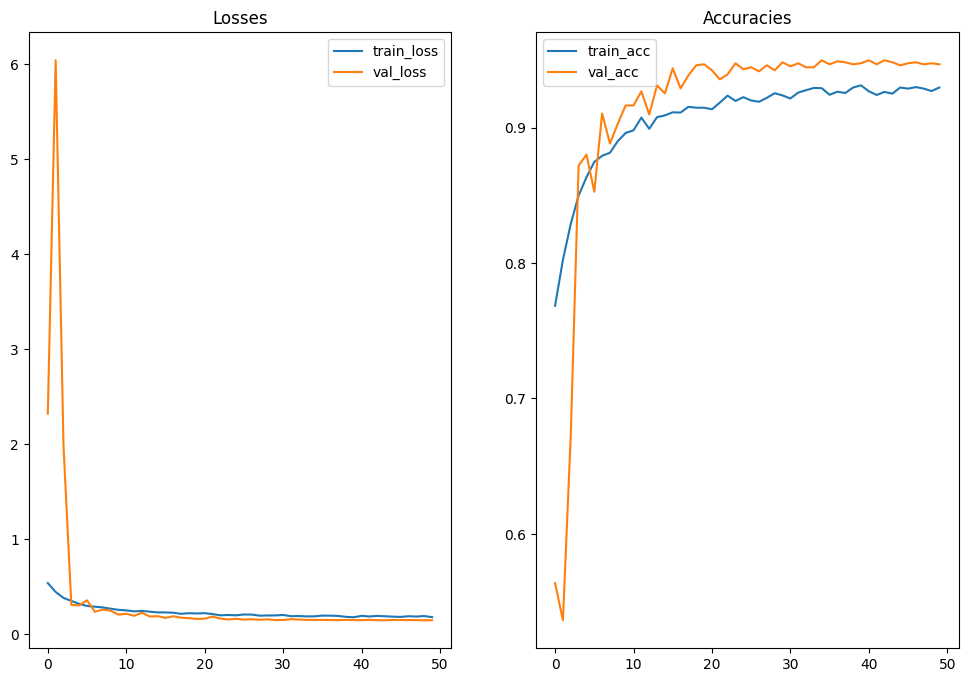

In [16]:
N = np.arange(0, NUM_EPOCHS)

plt.figure(figsize=(12,8))

plt.subplot(121)
plt.title("Losses")
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(122)
plt.title("Accuracies")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.legend()

plt.savefig("output/training_plot.png")

In [17]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('/content/output/Fire_and_Smoke_Detection.h5')

[INFO] loading model...


In [18]:

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, validation_data, validation_labels, classes):
    # Tính toán dự đoán trên tập validation_data
    predictions = model.predict(validation_data)

    # Chuyển đổi dự đoán thành nhãn dự đoán (lớp dương hoặc lớp âm)
    predicted_labels = np.argmax(predictions, axis=1)
    # Chuyển đổi nhãn thực tế thành lớp dương hoặc lớp âm
    true_labels = np.argmax(validation_labels, axis=1)

    # Tính toán các chỉ số precision, recall, và F1-score
    print(classification_report(true_labels, predicted_labels, target_names=classes))

    # Tính toán confusion matrix
    print("Confusion matrix:")
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Tính toán ROC curve và AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    # In đồ thị ROC curve
    print("\nIn đồ thị ROC curve:")
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Tính toán độ chính xác (accuracy)
    accuracy = model.evaluate(validation_data, validation_labels)[1]
    print("Accuracy:", accuracy)



43/43 [==============================] - 1s 8ms/step
                    precision    recall  f1-score   support

Non-Fire and Smoke       0.93      0.96      0.95       655
    Fire and Smoke       0.96      0.93      0.95       695

          accuracy                           0.95      1350
         macro avg       0.95      0.95      0.95      1350
      weighted avg       0.95      0.95      0.95      1350

Confusion matrix:


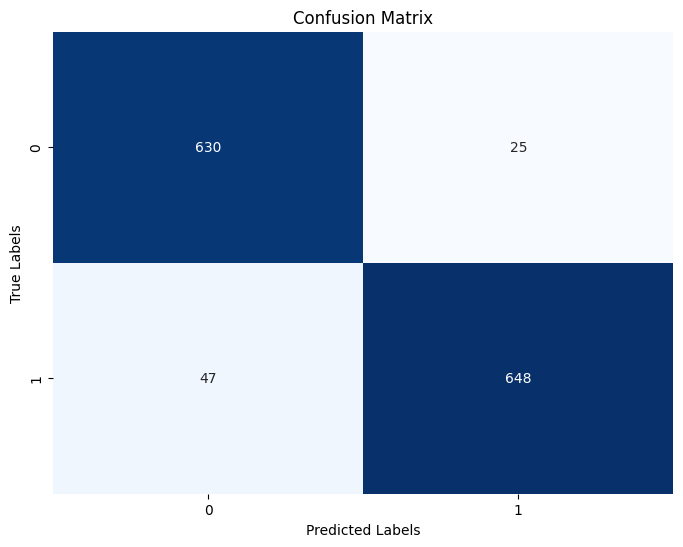


In đồ thị ROC curve:


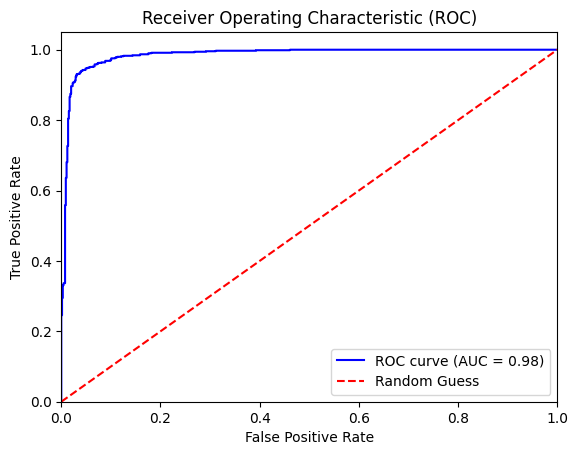

43/43 [==============================] - 1s 10ms/step - loss: 0.1523 - accuracy: 0.9467
Accuracy: 0.9466666579246521


In [19]:
evaluate_model(model, test_data, test_labels, classes)

In [20]:
os.makedirs('output/testing')

for i in range(1,21):
    random_index = np.random.randint(0,len(test_data))
    org_img = test_data[random_index]*255
    img = org_img.copy()
    img = cv2.resize(img,(128,128))
    img = img.astype('float32')/256
    pred = model.predict(np.expand_dims(img,axis=0))[0]
    result = classes[np.argmax(pred)]
    org_img = cv2.resize(org_img,(500,500))
    cv2.putText(org_img, result, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 3)
    cv2.imwrite('output/testing/{}.png'.format(i),org_img)

1/1 [==============================] - 0s 20ms/step
